In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!ls "/content/drive/My Drive/TFINAL_data/data/2018"

intertass-ES-dev.csv  intertass-ES-test.csv  intertass-ES-train.csv  results


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,SpatialDropout1D
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, MaxPooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from gensim.models.keyedvectors import KeyedVectors
from keras.models import Sequential, load_model

from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords 
import string, re
import keras
import pickle

from gensim.models.wrappers import FastText

Using TensorFlow backend.


In [0]:
DRIVE_FOLDER = '/content/drive/My Drive/TFINAL_data/'
EMBEDDING_FILE_FASTTEX_VEC='embeddings/fasttext-sbwc.vec'
#EMBEDDING_FILE_FASTTEX_BIN='embeddings/fasttext-sbwc.bin'

EMBEDDING_FILE_GLOVE_VEC='embeddings/glove-sbwc.i25.vec'
#EMBEDDING_FILE_GLOVE_BIN='embeddings/glove-sbwc.i25.bin'

EMBEDDING_MATRIX_FOLDER = 'matrix_emb/'
EMBEDDING_MATRIX_FILE_NAME = 'matrix_embeddings.csv'

# TRAIN_DATA_FILE='data/2017/task1-Train.csv'
# DEV_DATA_FILE='data/2017/task1-Dev.csv'
# TEST_DATA_FILE='data/2017/task1-Test.csv'

TRAIN_DATA_FILE='data/2018/intertass-ES-train.csv'
DEV_DATA_FILE='data/2018/intertass-ES-dev.csv'
TEST_DATA_FILE='data/2018/intertass-ES-test.csv'

RESULTS_2017='data/2017/results/'
RESULTS_2018='data/2018/results/'

TRAIN_GENERAL_DATA_FILE = 'data/train_general3l.csv'
# TRAIN_GENERAL_COMBINED_FILE = 'train_general_combined.csv'
DATA_GENERATE_FOLDER = 'data/data_generada/'

##Parameters
EMBEDDING_DIMENSION = 300
#max_features = 5000
max_features = 3000 
MAX_TWEET_LENGTH = 15 #initialization

In [0]:
cols = ['tweet','sentiment']

df_gral = pd.read_csv(os.path.join(DRIVE_FOLDER,TRAIN_GENERAL_DATA_FILE),header=None, names=cols)
df_gral.head()
# train_limit

total = df_gral.shape[0]


# df_t = pd.DataFrame(np.random.randn(100, 2))

msk = np.random.rand(df_gral.shape[0]) < 0.8

df_tr = df_gral[msk]

df_dev = df_gral[~msk]

msk2 = np.random.rand(df_tr.shape[0]) < 0.8

df_train = df_tr[msk2]
df_test = df_tr[~msk2]
df_train.reset_index(drop=True, inplace=True)
df_dev.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

assert df_train.shape[0]+df_dev.shape[0]+df_test.shape[0] == total, "bad split!"

In [5]:
N_TRAIN_EXAMPLES = df_train.shape[0]
N_TEST_EXAMPLES = df_test.shape[0]
print('train df: ',df_train.shape)
print('dev df: ',df_dev.shape)
print('test df: ',df_test.shape)
total,df_test.head()

train df:  (4597, 2)
dev df:  (1487, 2)
test df:  (1134, 2)


(7218,                                                tweet sentiment
 0                  #programascambiados caca d ajuste         N
 1  Noooooos días! Me he dormidoooooo ya estoy en ...      NONE
 2  La Universidad confía en De la Calle para enca...         P
 3  Accidente en BUS-VAO A-6 km. 12. Motorista de ...         N
 4  Mis #FF xa @merpastor x volver a sonreír, a @G...         P)

In [0]:

##test
# cols = ['tweet','sentiment']
# df_train = pd.read_csv(os.path.join(DRIVE_FOLDER,TRAIN_DATA_FILE),header=None, names=cols)
# df_dev = pd.read_csv(os.path.join(DRIVE_FOLDER,DEV_DATA_FILE),header=None, names=cols)
# df_test = pd.read_csv(os.path.join(DRIVE_FOLDER,TEST_DATA_FILE),header=None, names=cols)

# N_TRAIN_EXAMPLES = df_train.shape[0]
# N_TEST_EXAMPLES = df_test.shape[0]
# print('train df: ',df_train.shape)
# print('dev df: ',df_dev.shape)
# print('test df: ',df_test.shape)
# df_test.head()

### Pre-procesamiento

In [0]:
list_sentences_train = df_train["tweet"].values
list_sentences_dev = df_dev["tweet"].values
list_sentences_test = df_test["tweet"].values
labels_train = df_train["sentiment"].values
labels_dev = df_dev["sentiment"].values

In [8]:
len(list_sentences_train)

4597

In [0]:
## Functions for cleaning data
def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)
    
def remove_urls(input_text):
    return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)

def remove_digits(input_text):
    return re.sub('\d+', '', input_text)
    
def stemming(input_text):
    porter = PorterStemmer()
    words = input_text.split() 
    
    stemmed_words = [porter.stem(word) for word in words]
    return " ".join(stemmed_words)
    
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('spanish')
    words = input_text.split() 
    whitelist = ["no"]
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

def replace_accents(input_text):
    
    input_text = re.sub(u"[àáâãäå]", 'a', input_text)
    input_text = re.sub(u"[èéêë]", 'e', input_text)
    input_text = re.sub(u"[ìíîï]", 'i', input_text)
    input_text = re.sub(u"[òóôõö]", 'o', input_text)
    input_text = re.sub(u"[ùúûü]", 'u', input_text)
    input_text = re.sub(u"[ýÿ]", 'y', input_text)
    return input_text

def to_lower(input_text):
    return input_text.lower()

def remove_punctuation(input_text):
    # Make translation table
    punct = string.punctuation
    punct = punct+'¡'+'?'+'¿'+'…'
    trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
    input_text = re.sub("[\.][\.][\.]", " ", input_text)
    return input_text.translate(trantab)


def processJaja(word):
    dirtyJaja = re.compile(r'[ja]{5,}')
    dirtyJeje = re.compile(r'[je]{5,}')
    dirtyHihi = re.compile(r'[hi]{5,}')
    dirtyJaj = re.compile(r'[a-zA-z]+ja{2,}')
    while dirtyJaja.search(word)!=None:
        word = word.replace(dirtyJaja.search(word).group(),'jaja')
    while dirtyJeje.search(word)!=None:
        word = word.replace(dirtyJeje.search(word).group(),'jaja')
    while dirtyHihi.search(word)!=None:
        word = word.replace(dirtyHihi.search(word).group(),'jaja')
    while dirtyJaj.search(word)!=None:
        word = word.replace(dirtyJaj.search(word).group(),'jaja')
    
    return word    

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
## Cleaning data
def clean_data(list_sentences):
    clean_tweet_texts = []
    i=0
    for sentence  in list_sentences:
        #print('**- ',i,' ',sentence)
        if sentence != 'nan':
            clean_text = remove_mentions(sentence)
            clean_text = remove_urls(clean_text)
            clean_text = remove_punctuation(clean_text)
            clean_text = replace_accents(clean_text)
            clean_text = remove_digits(clean_text)
            clean_text = to_lower(clean_text)
            clean_text = remove_stopwords(clean_text)
            clean_text = processJaja(clean_text)
            clean_text = remove_emoji(clean_text)
            #clean_text = stemming(clean_text)
            clean_tweet_texts.append(clean_text)
        i+=1
    return clean_tweet_texts

In [33]:
!python


Python 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> import nltk
>>> nltk.download('stopwords')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
True
>>> exit()


In [0]:
list_sentences_train_clean = clean_data(list_sentences_train)
list_sentences_dev_clean = clean_data(list_sentences_dev)
list_sentences_test_clean = clean_data(list_sentences_test)

In [0]:
list_sentences_train_clean

In [12]:
 df_train.tweet[0]
 len(df_train)

4597

**Estimar longitud maxima de tweet**

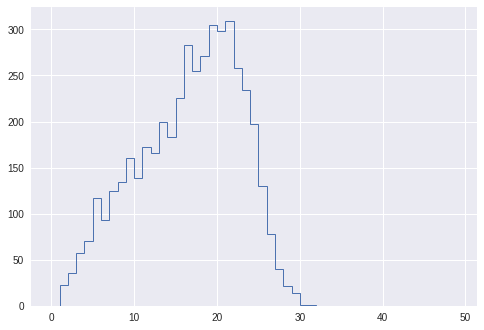

In [13]:
lengths = []
for i in range(len(df_train)):
    sentence = df_train.tweet[i]
    l = len(sentence.split())
    lengths.append(l)

import matplotlib.pyplot as plt
plt.hist(lengths, bins=np.arange(max(lengths)), histtype='step', linewidth=1);
plt.show()

In [0]:
MAX_TWEET_LENGTH = 25

In [0]:
#TOKENIZATION, INDEXING AND PADDING
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train_clean))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train_clean)
list_tokenized_dev = tokenizer.texts_to_sequences(list_sentences_dev_clean)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test_clean)


X_train = pad_sequences(list_tokenized_train, maxlen=MAX_TWEET_LENGTH)
X_dev = pad_sequences(list_tokenized_dev, maxlen=MAX_TWEET_LENGTH)
X_test = pad_sequences(list_tokenized_test, maxlen=MAX_TWEET_LENGTH)

In [16]:
X_test

array([[   0,    0,    0, ...,    0,    0,  385],
       [   0,    0,    0, ...,  125,  533,  767],
       [   0,    0,    0, ...,  174, 1582,    3],
       ...,
       [   0,    0,    0, ...,   28, 2362,  676],
       [   0,    0,    0, ...,    0, 1451,    8],
       [   0,    0,    0, ...,    0, 1355,  163]], dtype=int32)

**Categorizar etiquetas**

In [50]:
df_train["sentiment"].value_counts()

1    1851
0    1358
3     951
2     437
Name: sentiment, dtype: int64

In [51]:
df_dev["sentiment"].value_counts()

1    591
0    469
3    296
2    131
Name: sentiment, dtype: int64

In [52]:
df_test["sentiment"].value_counts()

1    442
0    355
3    235
2    102
Name: sentiment, dtype: int64

In [18]:
## One hot categorical labels
cleanup_nums = {"sentiment": {'N': 0, 'P': 1,'NEU':2,'NONE':3}}
df_train.replace(cleanup_nums, inplace=True)
df_dev.replace(cleanup_nums, inplace=True)
df_test.replace(cleanup_nums, inplace=True)

y_train = keras.utils.to_categorical(df_train.sentiment)
y_dev = keras.utils.to_categorical(df_dev.sentiment)
y_test = keras.utils.to_categorical(df_test.sentiment)

y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:4550: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [19]:
y_train.shape, y_dev.shape, y_test.shape

((4597, 4), (1487, 4), (1134, 4))

In [21]:
y_test

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [55]:
##test
# sentiment": {'N': 0, 'P': 1,'NEU':2,'NONE':3}

print('train \n',df_train["sentiment"].value_counts())
print('dev \n',df_dev["sentiment"].value_counts())
print('test \n',df_test["sentiment"].value_counts())

train 
 1    1851
0    1358
3     951
2     437
Name: sentiment, dtype: int64
dev 
 1    591
0    469
3    296
2    131
Name: sentiment, dtype: int64
test 
 1    442
0    355
3    235
2    102
Name: sentiment, dtype: int64


In [23]:
## test
y_train

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

### Cargar Word Embeddings

In [0]:
def load_embeddings(we_type):
    wordvectors_vec_file = ''
    if we_type=='fasttext':
        print('Loading Fasttext embeddings...')
        wordvectors_vec_file = os.path.join(DRIVE_FOLDER,EMBEDDING_FILE_FASTTEX_VEC)
    if we_type == 'glove': 
        print('Loading Glove embeddings...')
        wordvectors_vec_file = EMBEDDING_FILE_GLOVE_VEC
    wordvectors = KeyedVectors.load_word2vec_format(wordvectors_vec_file)
    return wordvectors

def create_emb_dict(words, emb_dimension):
    emb_dict = {}
    size = len(words)
    for i in range(size):
        word = words[i]
        vector = np.array(wordvectors[words[i]], dtype=np.float32)
        if vector.shape[0]== emb_dimension:
            emb_dict[word] = vector
    return emb_dict
# array: ['de','la','a'...] of WordEmbeddings
def create_words_vocab(vocab):
    words = []
    for word in vocab:
        words.append(word)
    return words

In [0]:
#********************************
#LOAD PRETRAINED VECTORS
wordvectors = load_embeddings('fasttext')
#wordvectors = load_embeddings('glove')



In [0]:

#********************************
#Create word embeddings dictionary
emb_words_vocab = create_words_vocab(wordvectors.vocab)
emb_dict = create_emb_dict(emb_words_vocab,EMBEDDING_DIMENSION)

#********************************
##save embeddings dictionary
#pickle_out = open(os.path.join(os.path.join(DRIVE_FOLDER,DATA_GENERATE_FOLDER),"emb_dict_fasttext222.pickle"),"wb")
#pickle.dump(emb_dict, pickle_out)
#pickle_out.close()

In [0]:
pickle_out = open(os.path.join(os.path.join(DRIVE_FOLDER,DATA_GENERATE_FOLDER),"emb_dict_fasttext.pickle"),"wb")
pickle.dump(emb_dict, pickle_out)
pickle_out.close()

In [0]:
#load embedding dictionary
pickle_in = open(os.path.join(DRIVE_FOLDER,DATA_GENERATE_FOLDER,"emb_dict_fasttext.pickle"),"rb")
emb_dict = pickle.load(pickle_in)

In [0]:
emb_dict

In [0]:
#STAKING WORD VECTORS
all_embs = np.stack(emb_dict.values())

In [28]:
##test
all_embs.shape

(855380, 300)

In [0]:
#CREATING VOCABULARY OF DATASET
word_index = tokenizer.word_index ##vocabulario de dataset
#nb_words = min(max_features, len(word_index))##numero de palabras en el vocabulario
nb_words = len(word_index)+1

In [30]:
nb_words

12002

### Embedding Matrix

In [0]:
#CREATING EMBEDDING MATRIX
#RANDOM INITIALIZATION FOR NO WORDS IN VOCABULARY WORD EMBEDDINGS

emb_mean,emb_std = all_embs.mean(), all_embs.std()#ranges
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, EMBEDDING_DIMENSION)) ##inicializar con numeros aleatorios
for word, i in word_index.items():
    if i >= nb_words: 
        continue
    embedding_vector = emb_dict.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [32]:
##test
max_features, len(word_index),embedding_matrix.shape, nb_words

(3000, 12001, (12002, 300), 12002)

In [33]:
##test
embedding_matrix

array([[ 0.1101718 ,  0.12845657,  0.00355512, ...,  0.18581652,
        -0.00726928, -0.13807592],
       [-0.045958  , -0.084632  , -0.085724  , ...,  0.0013008 ,
        -0.08545   , -0.12830999],
       [ 0.47615999,  0.35605001, -0.23711   , ...,  0.041137  ,
        -0.035328  , -0.40505999],
       ...,
       [ 0.24260999, -0.15072   ,  0.75225002, ...,  0.16693   ,
         0.11513   ,  0.086342  ],
       [ 0.42401001, -0.50834   ,  0.25207001, ...,  0.038367  ,
         0.22668999, -0.40498   ],
       [-0.23896   , -0.1529    ,  0.1495    , ..., -0.020794  ,
        -0.11433   , -0.25757   ]])

**Words not found**

In [0]:
words_not_found = []
for word, i in word_index.items():
    if i >= nb_words: 
        continue
    embedding_vector = emb_dict.get(word)
    if embedding_vector is None: 
        words_not_found.append(word)

In [0]:
#FUNCTION FOR PLOT TRAIN-VALIDATION LOSS
from matplotlib import pyplot
def plot_train_test_loss_acc(history):
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model train vs validation loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper right')
    pyplot.show()

### Train-Test split

In [0]:
# from sklearn.model_selection import train_test_split
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X_t, y_train, test_size=0.2)

# X_train2, X_val, y_train2, y_val = train_test_split(X_train2, y_train2, test_size=0.2)

# print ('train set: ',X_train2.shape, y_train2.shape)
# print ('val set: ',X_val.shape, y_val.shape)
# print ('test set: ',X_test2.shape, y_test2.shape)

train set:  (644, 25) (644, 4)
val set:  (162, 25) (162, 4)
test set:  (202, 25) (202, 4)


Test dataset preparation

In [36]:
X_train.shape, X_dev.shape
# X_train

((4597, 25), (1487, 25))

### Model: Multilayer Bidirectional LSTM

value parameter:  0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 300)           3600600   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 25, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 25, 400)           801600    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400)               961600    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1604      
Total params: 5,365,404
Trainable params: 1,764,804
Non-trainable p

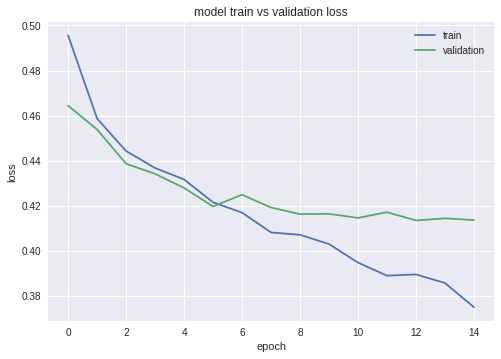

In [37]:
num_lstm =  [200, 128, 64, 32]
#dropout = 0.4
#recurrent_dropout = 0.45
#spatial_dropout = 0.3

dropout = 0.5
recurrent_dropout = 0.5
spatial_dropout = 0.4

#####spatial_dropout = 0.6 #remove maps(word embedding) instead individual elements
# evitar overfit en palabras especificas
#S1: "The big brown dog was playing with another black dog"
#if we apply dropout 0.2, the sentence can be translated both as S1' and S1''
#S1': "The big brown - was playing with another black -"
#S1'':"The big - dog was playing with another black -"
num_lstms = [16, 32, 64, 100, 128, 200, 256, 300, 400]
dropouts = [0.2, 0.3, 0.4, 0.45 ,0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1]
recurrent_dropouts = [0.2, 0.3, 0.4, 0.45 ,0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1]
spatial_dropouts = [0.2, 0.3, 0.4, 0.45 ,0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1]
i=1
for i in range(i):
    print('value parameter: ',i)
    model = Sequential()
    embedding_layer = Embedding(nb_words,EMBEDDING_DIMENSION,weights=[embedding_matrix],input_length = MAX_TWEET_LENGTH,trainable=False)

    model.add(embedding_layer)
    model.add(SpatialDropout1D(spatial_dropout))
    
    model.add(Bidirectional(LSTM(units = num_lstm[0],return_sequences=True,dropout = dropout, recurrent_dropout = recurrent_dropout)))
    #model.add(Bidirectional(LSTM(units = num_lstm[1],return_sequences=True,dropout = dropout, recurrent_dropout = recurrent_dropout)))
    #model.add(Bidirectional(LSTM(units = num_lstm[2],return_sequences=True,dropout = dropout, recurrent_dropout = recurrent_dropout)))
    
    model.add(Bidirectional(LSTM(units = num_lstm[0],dropout = dropout, recurrent_dropout = recurrent_dropout)))
    model.add(Dense(4, activation="sigmoid"))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    print(model.summary())


    n_epochs= 15
    batch_size = 8
#     history = model.fit(X_train2, y_train2, epochs=n_epochs, batch_size=batch_size,verbose=1, validation_data=(X_val, y_val), shuffle=False)
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,verbose=1, validation_data=(X_dev, y_dev), shuffle=False)
    
    score,acc = model.evaluate(X_dev, y_dev, verbose = 1)
    print("score: %.2f" % (score))
    print("acc: %.2f" % (acc))

#     scores = model.evaluate(X_test2, y_test2, verbose=0)
#     print("Accuracy: %.2f%%" % (scores[1]*100))

    plot_train_test_loss_acc(history)


In [38]:
ynew = model.predict(X_test)
ynew

array([[0.6716151 , 0.19568011, 0.05575147, 0.11344364],
       [0.14365795, 0.52418655, 0.04214266, 0.27041867],
       [0.12853694, 0.5915049 , 0.0487608 , 0.1841329 ],
       ...,
       [0.7412139 , 0.08088055, 0.12084648, 0.05407262],
       [0.40317923, 0.21739271, 0.05727273, 0.3049614 ],
       [0.08276725, 0.3227412 , 0.02661958, 0.520058  ]], dtype=float32)

In [0]:
y_new_int = []
def decode(datum):
    return np.argmax(datum)
  
for i in range(ynew.shape[0]):
    datum = ynew[i]
    y_new_int.append(decode(ynew[i]))

y_new_int


In [0]:
# sentiment": {'N': 0, 'P': 1,'NEU':2,'NONE':3}
y_test_int=[]
for lb in y_test:
  y_test_int.append(list(lb).index(1.))

y_test_int

In [49]:
from sklearn.metrics import *
acc = accuracy_score(y_test_int, y_new_int)
f1 = f1_score(y_test_int, y_new_int, average='macro')
print('accuracy: ',acc)
print('F1: ',f1)

accuracy:  0.5978835978835979
F1:  0.4548793530064076


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
cols = ['id','tweet','sentiment']
df_test = pd.read_csv(os.path.join(DRIVE_FOLDER,TEST_DATA_FILE),header=None, names=cols)

N_TRAIN_EXAMPLES = df_test.shape[0]
print('df_test df: ',df_test.shape)



In [0]:
dictionary = dict(zip(list(df_test.id), y_test_int))
dictionary

In [0]:
import csv
# sentiment": {'N': 0, 'P': 1,'NEU':2,'NONE':3}
fieldnames = ('tweet_id', 'polarity')
csv_filename = RESULTS_2018+"results.csv"
with open(os.path.join(DRIVE_FOLDER,csv_filename), 'w') as f:
    for key in dictionary.keys():
      value=''
      if dictionary[key]==0:
        value = 'N'
      if dictionary[key]==1:
        value = 'P'
      if dictionary[key]==2:
        value = 'NEU'
      if dictionary[key]==3:
        value = 'NONE'
      
      f.write("%s\t%s\n"%(key,value))